## Loan Default Prediction

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Описание датасета**

* **Id** - Идентификатор строки
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Загрузка модулей и исходных данных

In [1]:
import re
import pickle
import random
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка тренировочных и тестовых данных
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
# Целевая переменная
TARGET_NAME = 'Credit Default'

### Обзор обучающего датасета

In [3]:
data_train.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

#### Распределение целевой переменной

In [5]:
data_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

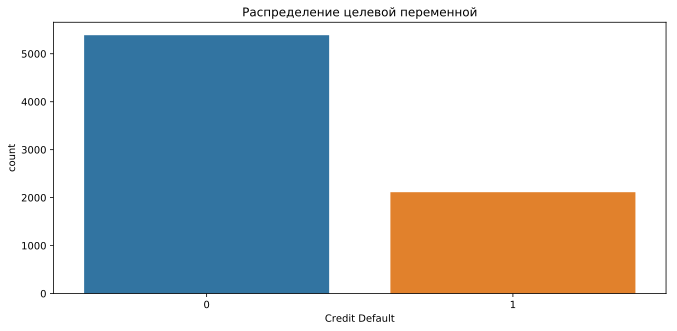

In [6]:
plt.figure(figsize=(11, 5))
sns.countplot(x='Credit Default', data=data_train)
plt.title('Распределение целевой переменной')
plt.show()

In [7]:
# Размерность исходных данных (до чистки)
data_train.shape

(7500, 18)

#### Выделим числовые и категориальные признаки

In [8]:
categorical_columns = [c for c in data_train.columns if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns if data_train[c].dtype.name != 'object' and data_train[c].name != TARGET_NAME and data_train[c].name != 'Id']

In [9]:
categorical_columns

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [10]:
numerical_columns

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Обработка выбросов

In [11]:
data_train.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Из таблицы data_train.describe() видно, что данные требуют предварительной отчистки от выбросов. Для этого напишем функцию, которая выявляет значения в определенном диапазоне числовых значений (полей числовых типов).

In [12]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        # 1-й квартиль (25%)
        Q1 = np.percentile(df[col], 25)
        # 3-й квартиль (75%)
        Q3 = np.percentile(df[col], 75)
        # Дипазон межквартиля (IQR)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        # Определение списка индексов отклонения
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # Добавить найденные индексы отклонения
        outlier_indices.extend(outlier_list_col)
        
    # Выбрать наблюдения, содержащие более 2 отклонений
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [13]:
outliers_to_drop = detect_outliers(data_train, 2, numerical_columns)

In [14]:
data_train.loc[outliers_to_drop].head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
221,221,Own Home,1485857.0,< 1 year,1.0,10.0,10.0,407946.0,1.0,NaN,0.0,other,Short Term,99999999.0,98287.0,19811.0,703.0,0
254,254,Home Mortgage,1162572.0,2 years,2.0,11.0,36.5,928598.0,2.0,41.0,0.0,debt consolidation,Long Term,358974.0,441085.0,18601.0,738.0,0
286,286,Rent,1208324.0,10+ years,1.0,17.0,16.9,1875918.0,1.0,NaN,0.0,debt consolidation,Long Term,402512.0,635075.0,29302.0,688.0,1
478,478,Rent,1521520.0,8 years,1.0,23.0,18.1,1770076.0,1.0,56.0,0.0,debt consolidation,Long Term,535678.0,1096091.0,48055.0,653.0,1
1214,1214,Rent,3061584.0,2 years,6.0,14.0,28.9,949564.0,6.0,67.0,0.0,debt consolidation,Short Term,99999999.0,352640.0,29595.0,740.0,0


In [15]:
data_train.loc[outliers_to_drop].shape

(189, 18)

Мы обнаружили достаточно большое количество отклонений в наборе данных, что составляет значительный % наших данных. Почистим эти отклонения.

In [16]:
data_train = data_train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 18 columns):
Id                              7311 non-null int64
Home Ownership                  7311 non-null object
Annual Income                   5793 non-null float64
Years in current job            6950 non-null object
Tax Liens                       7311 non-null float64
Number of Open Accounts         7311 non-null float64
Years of Credit History         7311 non-null float64
Maximum Open Credit             7311 non-null float64
Number of Credit Problems       7311 non-null float64
Months since last delinquent    3333 non-null float64
Bankruptcies                    7297 non-null float64
Purpose                         7311 non-null object
Term                            7311 non-null object
Current Loan Amount             7311 non-null float64
Current Credit Balance          7311 non-null float64
Monthly Debt                    7311 non-null float64
Credit Score                    579

In [18]:
# Размерность исходных данных (после удаления выбросов)
data_train.shape

(7311, 18)

### Обработка пропусков

*При заполнении недостающих параметров делаем следующие допущения:*
1. Годовой доход (Annual Income) считаем по медианному значению
2. Количество месяцев с последней просрочки платежа (Months since last delinquent) считаем, что NaN - это просрочки не было вообще и указываем 999999 месяцев
3. Кредитный скоринг (Credit Score) считаем по медианному значению
4. Банкротство (Bankruptcies) считаем по моде

In [19]:
data_train['Annual Income'] = data_train['Annual Income'].fillna(data_train['Annual Income'].median())
data_train['Months since last delinquent'] = data_train['Months since last delinquent'].fillna(99999999)
data_train['Credit Score'] = data_train['Credit Score'].fillna(data_train['Credit Score'].median())
data_train['Bankruptcies'] = data_train['Bankruptcies'].fillna(0)

В исходном наборе присуствует достаточно важное поле Years in current job (количество лет на текущем месте работы), которое у нас не числового типа и оно не заполнено полностью. Для дальнейшего анализа данных необходимо из данного поля сделать новый признак уже числового типа и заполнить его.

In [20]:
data_train['Years in current job 2'] = data_train['Years in current job'].str.extract(r'(\d+)', expand=False)
data_train['Years in current job 2'] = data_train['Years in current job 2'].astype('float64')
data_train['Years in current job 2'] = data_train['Years in current job 2'].fillna(data_train['Years in current job 2'].median())

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 19 columns):
Id                              7311 non-null int64
Home Ownership                  7311 non-null object
Annual Income                   7311 non-null float64
Years in current job            6950 non-null object
Tax Liens                       7311 non-null float64
Number of Open Accounts         7311 non-null float64
Years of Credit History         7311 non-null float64
Maximum Open Credit             7311 non-null float64
Number of Credit Problems       7311 non-null float64
Months since last delinquent    7311 non-null float64
Bankruptcies                    7311 non-null float64
Purpose                         7311 non-null object
Term                            7311 non-null object
Current Loan Amount             7311 non-null float64
Current Credit Balance          7311 non-null float64
Monthly Debt                    7311 non-null float64
Credit Score                    731

### Отбор признаков

Добавляем новый признак 'Years in current job 2' к числовым признакам и в тоже время удалим из категориальных признаков 'Years in current job'

In [22]:
numerical_columns.append('Years in current job 2')
numerical_columns

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years in current job 2']

In [23]:
categorical_columns.remove('Years in current job')
categorical_columns

['Home Ownership', 'Purpose', 'Term']

Посмотрим полный перечень значений (уникальных) категориальных признаков для определения бинарных и небинарных признаков

In [24]:
for c in categorical_columns:
    print(data_train[c].unique())

['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']
['Short Term' 'Long Term']


In [25]:
data_describe = data_train.describe(include=[object])

binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Term'] ['Home Ownership', 'Purpose']


Как видно из полученных значений, признак 'Term' является бинарным, а 'Home Ownership', 'Purpose' не бинарные категориальные признаки

#### Обработка бинарных признаков

In [26]:
data_train.at[data_train['Term'] == 'Short Term', 'Term'] = 0
data_train.at[data_train['Term'] == 'Long Term', 'Term'] = 1
data_train['Term'].describe()

count    7311.000000
mean        0.257967
std         0.437546
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Term, dtype: float64

#### Обработка небинарных признаков

In [27]:
data_nonbinary = pd.get_dummies(data_train[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')


#### Соединим все столбцы в одну таблицу

In [28]:
data_train = pd.concat([data_train, data_nonbinary], axis=1)

In [29]:
FEATURE_NAMES_SELECTED = numerical_columns + data_nonbinary.columns.tolist()
FEATURE_NAMES_SELECTED

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years in current job 2',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

In [30]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 38 columns):
Id                              7311 non-null int64
Home Ownership                  7311 non-null object
Annual Income                   7311 non-null float64
Years in current job            6950 non-null object
Tax Liens                       7311 non-null float64
Number of Open Accounts         7311 non-null float64
Years of Credit History         7311 non-null float64
Maximum Open Credit             7311 non-null float64
Number of Credit Problems       7311 non-null float64
Months since last delinquent    7311 non-null float64
Bankruptcies                    7311 non-null float64
Purpose                         7311 non-null object
Term                            7311 non-null int64
Current Loan Amount             7311 non-null float64
Current Credit Balance          7311 non-null float64
Monthly Debt                    7311 non-null float64
Credit Score                    7311

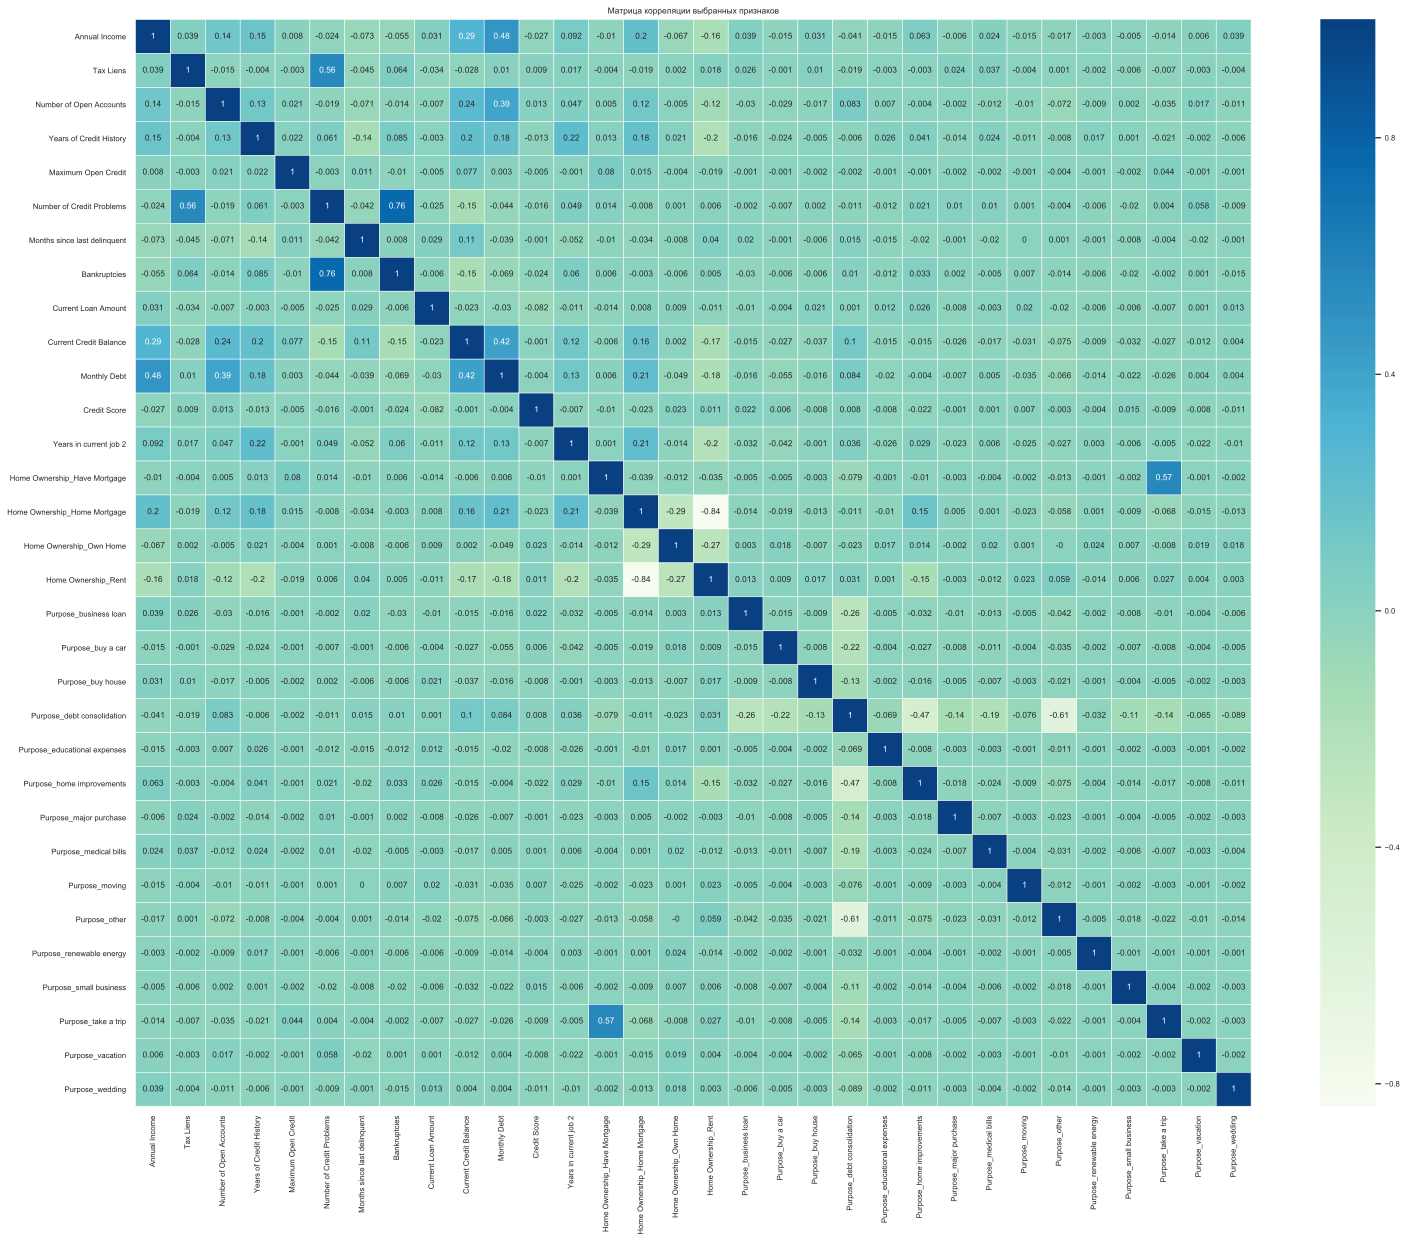

In [31]:
plt.figure(figsize = (25, 20))

sns.set(font_scale=0.7)
sns.heatmap(data_train[FEATURE_NAMES_SELECTED].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляции выбранных признаков')
plt.show()

### Подбор моделей

In [32]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [33]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Нормализация данных<a class="anchor" id="normalization"></a>

In [34]:
scaler = StandardScaler()

data_train_norm = data_train.copy()
data_train_norm[FEATURE_NAMES_SELECTED] = scaler.fit_transform(data_train_norm[FEATURE_NAMES_SELECTED])

data_train = data_train_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [35]:
X = data_train[FEATURE_NAMES_SELECTED]
y = data_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [36]:
FEATURE_NAMES_SELECTED

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Years in current job 2',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3955
1    3056
Name: Credit Default, dtype: int64

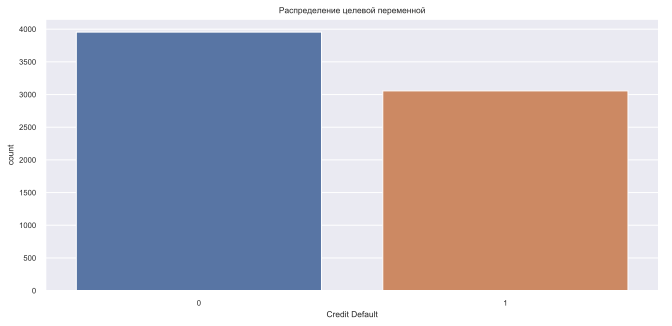

In [38]:
plt.figure(figsize=(11, 5))
sns.countplot(x='Credit Default', data=df_balanced)
plt.title('Распределение целевой переменной')
plt.show()

In [39]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Обучение модели

In [40]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3955
           1       0.87      0.72      0.78      3056

   micro avg       0.83      0.83      0.83      7011
   macro avg       0.84      0.82      0.82      7011
weighted avg       0.83      0.83      0.83      7011

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1285
           1       0.57      0.50      0.54       543

   micro avg       0.74      0.74      0.74      1828
   macro avg       0.69      0.67      0.68      1828
weighted avg       0.73      0.74      0.74      1828

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1083  202
1                270  273


#### Подбор гиперпараметров

In [41]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [42]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [43]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [44]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 8min 17s, sys: 38.2 s, total: 8min 55s
Wall time: 8min 18s


In [45]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05}

In [46]:
rs.best_score_

0.6916089736367108

**Обучение и оценка финальной модели**

In [47]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      3955
           1       0.86      0.69      0.76      3056

   micro avg       0.81      0.81      0.81      7011
   macro avg       0.82      0.80      0.80      7011
weighted avg       0.82      0.81      0.81      7011

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1285
           1       0.58      0.49      0.53       543

   micro avg       0.74      0.74      0.74      1828
   macro avg       0.69      0.67      0.68      1828
weighted avg       0.73      0.74      0.74      1828

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1088  197
1                275  268
CPU times: user 26.3 s, sys: 3.56 s, total: 29.8 s
Wall time: 4.11 s


In [48]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

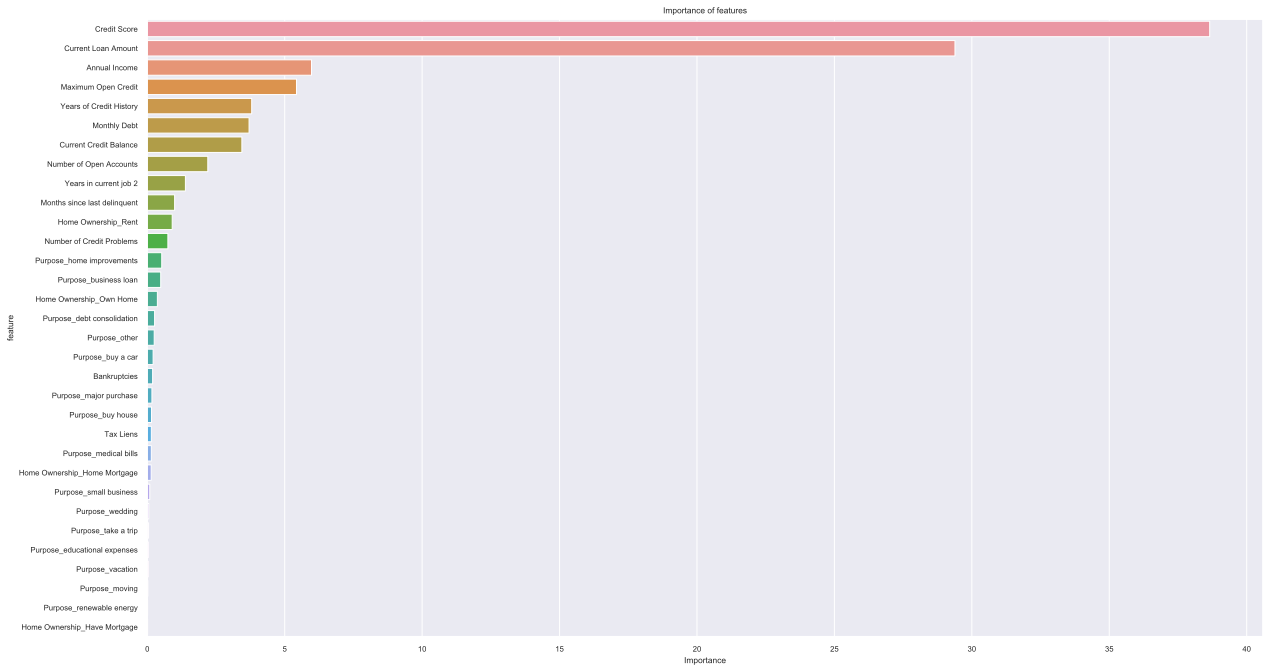

In [49]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [50]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job 2',
 'Months since last delinquent',
 'Home Ownership_Rent',
 'Number of Credit Problems',
 'Purpose_home improvements',
 'Purpose_business loan',
 'Home Ownership_Own Home']

In [51]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, l2_leaf_reg=10, silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.91      0.80      3955
           1       0.82      0.53      0.65      3056

   micro avg       0.74      0.74      0.74      7011
   macro avg       0.77      0.72      0.72      7011
weighted avg       0.76      0.74      0.73      7011

TEST

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1285
           1       0.61      0.45      0.52       543

   micro avg       0.75      0.75      0.75      1828
   macro avg       0.70      0.66      0.68      1828
weighted avg       0.74      0.75      0.74      1828

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1126  159
1                297  246


### Предсказания на тестовый данных

Переносим обработку данных, которую мы делали на тренировочном наборе data_train

In [52]:
data_test = pd.read_csv('data/test.csv')

In [53]:
# Размерность тестовых данных (до обработки)
data_test.shape

(2500, 17)

In [54]:
# Обработка пропусков
data_test['Annual Income'] = data_test['Annual Income'].fillna(data_test['Annual Income'].median())
data_test['Months since last delinquent'] = data_test['Months since last delinquent'].fillna(99999999)
data_test['Credit Score'] = data_test['Credit Score'].fillna(data_test['Credit Score'].median())
data_test['Bankruptcies'] = data_test['Bankruptcies'].fillna(0)
# Добавление нового числового признака
data_test['Years in current job 2'] = data_test['Years in current job'].str.extract(r'(\d+)', expand=False)
data_test['Years in current job 2'] = data_test['Years in current job 2'].astype('float64')
data_test['Years in current job 2'] = data_test['Years in current job 2'].fillna(data_test['Years in current job 2'].median())

In [55]:
# Обработка бинарных признаков
data_test.at[data_test['Term'] == 'Short Term', 'Term'] = 0
data_test.at[data_test['Term'] == 'Long Term', 'Term'] = 1

In [56]:
# Обработка небинарных признаков 
data_test_nonbinary = pd.get_dummies(data_test[nonbinary_columns])
data_test = pd.concat([data_test, data_test_nonbinary], axis=1)

In [57]:
FEATURE_NAMES_SELECTED.remove('Purpose_renewable energy')

In [58]:
# Нормализация данных
scaler = StandardScaler()
data_test_norm = data_test.copy()
data_test_norm[FEATURE_NAMES_SELECTED] = scaler.fit_transform(data_test_norm[FEATURE_NAMES_SELECTED])

data_test = data_test_norm.copy()

In [59]:
# Размерность тестовых данных (после обработки)
data_test.shape

(2500, 36)

In [60]:
# Проводим предсказание на тестовых данных
pred_test = final_model.predict(data_test.loc[:, FEATURE_NAMES_SELECTED])

In [61]:
data_test[TARGET_NAME] = pred_test
data_test[TARGET_NAME] = data_test[TARGET_NAME].astype('int')

In [62]:
# Сохраняем полученные предсказания
data_test.loc[:, ['Id', TARGET_NAME]].to_csv('data/NLitvak_predictions.csv', index=None)